# DGA Data Collection and Feature Exraction and Training Model

In [86]:
import numpy as np 
import pandas as pd
import math
from collections import Counter
import tldextract

### Data aquisition
First off we'll start by reading our data which we uploaded, data is split into two datasets. One coming from Alexa's ranking and another from various DGA domains

Our goal is to build a classifier which can differentiate between a legitimate domain name and a potential random one.

In [87]:
# Reading dga dataset
columns_dga = ["source","domain_name","date","second","first", "time"]

dga_domains = pd.read_csv("../data/DGA/dga_project_dga_domain_list_clean.txt", sep="\s+", names=columns_dga)
dga_domains.head()

,source,domain_name,date,second,first,time
0,nymaim,vvqbhhwma.org,2021-05-11,00:00:00,2021-05-11,23:59:59
1,nymaim,cfhauqbaz.com,2021-05-11,00:00:00,2021-05-11,23:59:59
2,nymaim,bvxjsbkqu.biz,2021-05-11,00:00:00,2021-05-11,23:59:59
3,nymaim,hggazskvkdy.com,2021-05-11,00:00:00,2021-05-11,23:59:59
4,nymaim,xgoqyxgfgm.com,2021-05-11,00:00:00,2021-05-11,23:59:59


In [88]:
# Removing none useful columns 
dga_domains.drop(["source", "date", "second", "first", "time"], axis=1, inplace=True)
dga_domains["label"] = "dga"

print("DGA Dataframe has {} rows".format(dga_domains.shape[0]))
dga_domains.head()

DGA Dataframe has 1404792 rows


,domain_name,label
0,vvqbhhwma.org,dga
1,cfhauqbaz.com,dga
2,bvxjsbkqu.biz,dga
3,hggazskvkdy.com,dga
4,xgoqyxgfgm.com,dga


In [89]:
# Readin Alexa data
legit_columns = ["domain_name"]

# legit_domains = pd.read_csv("/kaggle/input/domain-generation-algorithm/dga_project_top-1m.csv", names=legit_columns)
legit_domains = pd.read_csv("../data/DGA/top-1m.csv", names=legit_columns)
legit_domains["label"] = "legit"

print("Legit Dataframe has {} rows".format(legit_domains.shape[0]))
legit_domains.head()

Legit Dataframe has 694787 rows


,domain_name,label
1,google.com,legit
2,youtube.com,legit
3,tmall.com,legit
4,qq.com,legit
5,baidu.com,legit


In [90]:
# Adjusting datasets sizes and asserting that
dga_domains = dga_domains.loc[:legit_domains.shape[0]-1, :]

assert dga_domains.shape[0] == legit_domains.shape[0]

In [91]:
# Concatenating both datasets
data = pd.concat([dga_domains, legit_domains])

print("Whole Dataset has {} rows".format(data.shape[0]))
assert data.shape[0] == legit_domains.shape[0] * 2
data.head()

Whole Dataset has 1389574 rows


,domain_name,label
0,vvqbhhwma.org,dga
1,cfhauqbaz.com,dga
2,bvxjsbkqu.biz,dga
3,hggazskvkdy.com,dga
4,xgoqyxgfgm.com,dga


In [92]:
def entropy(domain_name):
    """ Function which computes the entropy of a given domain name based on it's chars """
    elements, length = Counter(domain_name), len(domain_name)    
    
    return -sum(element/length * math.log(element/length, 2) for element in elements.values())

In [93]:
def get_domain_name(domain):
    """ Function which extracts domain name from subdomain name """
    res = tldextract.extract(domain)
    return res.domain if len(res.domain) > len(res.subdomain) or entropy(res.domain) > entropy(res.subdomain) else res.subdomain


data["domain"] = data["domain_name"].apply(lambda domain: get_domain_name(domain))

In [94]:
# Applying functions above
data["length"] = data["domain"].apply(lambda domain: len(domain))
data["entropy"] = data["domain"].apply(lambda domain: entropy(domain))
data.head()

,domain_name,label,domain,length,entropy
0,vvqbhhwma.org,dga,vvqbhhwma,9,2.725481
1,cfhauqbaz.com,dga,cfhauqbaz,9,2.947703
2,bvxjsbkqu.biz,dga,bvxjsbkqu,9,2.947703
3,hggazskvkdy.com,dga,hggazskvkdy,11,3.095795
4,xgoqyxgfgm.com,dga,xgoqyxgfgm,10,2.646439


#### Few visual representation of those predictors by label

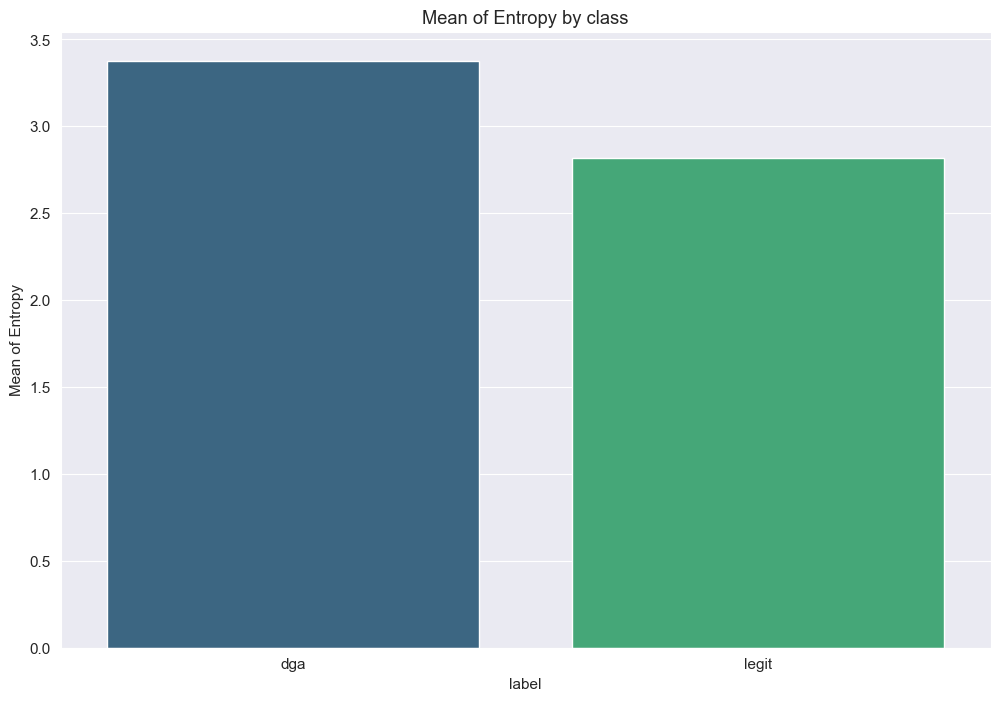

In [95]:
# Plots of those two columns

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 8)
font = {"size": 11}
plt.rc('font', **font)

mean_entropy = data.groupby("label")["entropy"].agg("mean").reset_index()  # Reset index to get label as a column
sns.barplot(x="label", y="entropy", data=mean_entropy, palette="viridis")

plt.ylabel("Mean of Entropy")
plt.title("Mean of Entropy by class")
plt.show()


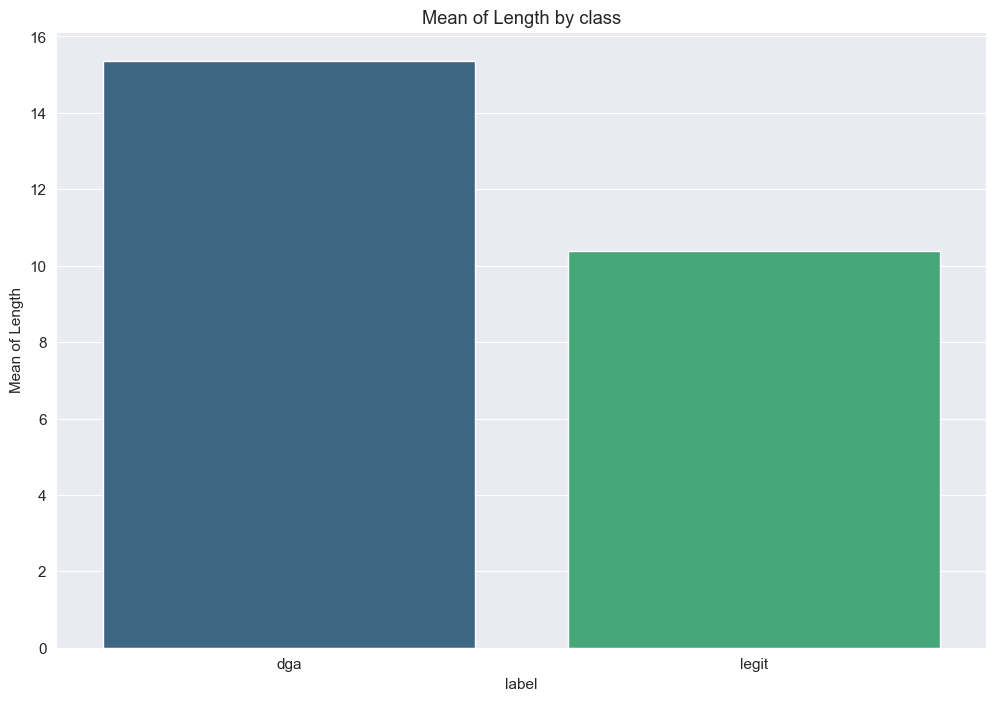

In [96]:
# plots of the mean entropy by class

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 8)
font = {"size": 11}
plt.rc('font', **font)

mean_length = data.groupby("label")["length"].agg("mean").reset_index()  # Reset index to get label as a column
sns.barplot(x="label", y="length", data=mean_length, palette="viridis")

plt.ylabel("Mean of Length")
plt.title("Mean of Length by class")
plt.show()


#### Preparing data for training, we'll use a boosting model then iterate over

In [97]:
# Creating feature and target vector

X = data[["length", "entropy"]]
y = data["label"]

In [98]:
# Creating train and test dataset with respect to a prior shuflle and a strtify

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, shuffle=True, stratify=y)

In [99]:
# Target variable encoding

from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [100]:
# Model training and prediction using lightbgm

import lightgbm as lgb


lgb_clf = lgb.LGBMClassifier()

lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)

[LightGBM] [Info] Number of positive: 555830, number of negative: 555829
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 305
[LightGBM] [Info] Number of data points in the train set: 1111659, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000002
[LightGBM] [Info] Start training from score 0.000002


In [101]:
# f1 score metric & accuracy

from sklearn.metrics import f1_score,accuracy_score

print("Accuracy score is {}%".format(round(accuracy_score(y_test, y_pred) * 100), 2))
print("Evaluation f1 score metric is {}%".format(round(f1_score(y_test, y_pred) * 100), 2))

Accuracy score is 88%
Evaluation f1 score metric is 88%


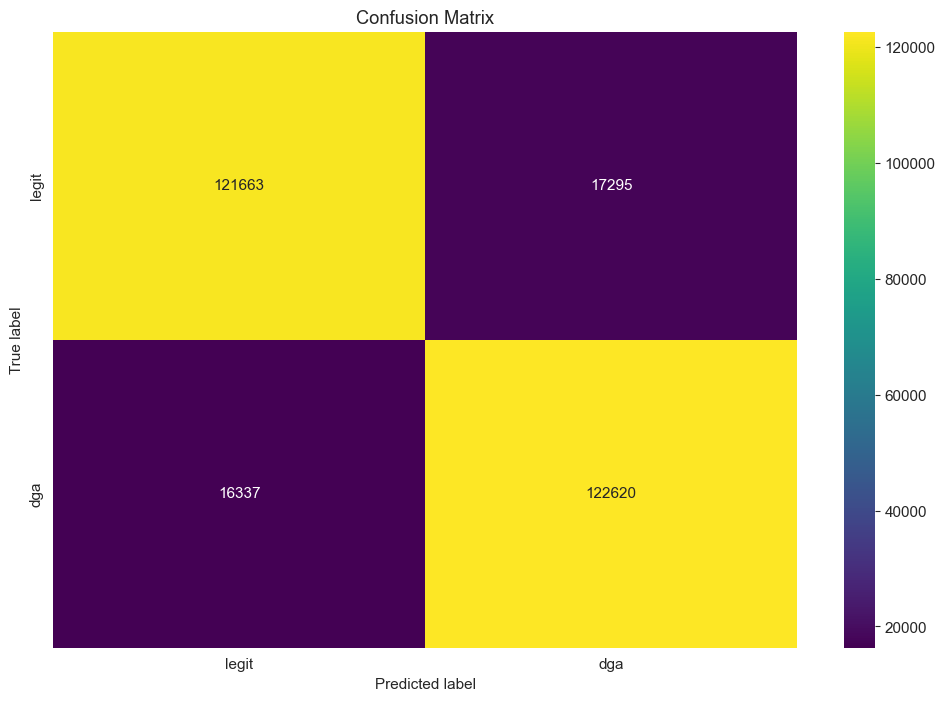

In [102]:
# Confusion matrix

# from sklearn.metrics import plot_confusion_matrix


# plot_confusion_matrix(lgb_clf, X_test, y_test, display_labels=["legit", "dga"])


from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=["legit", "dga"], yticklabels=["legit", "dga"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


Well clearly we can try to do better and work on some more complex Feature Engineering based on the lexical constructindisplay_labels=ach domain name.

We'll try to leverage how many occurence of grams we can find for each domain name in alexa grams (since they are legitimate) and in grams of word of an English dicitonary (could have added other languages...french, german etc..)

In [103]:
# A choice of 3 to 5 grams seems okay

from sklearn.feature_extraction.text import CountVectorizer


split_condition = data["label"] == "legit"
legit = data[split_condition]
dga = data[~split_condition]

alexa_vc = CountVectorizer(analyzer="char", ngram_range=(3,5), min_df=0.00001, max_df=1.0)
counts_matrix = alexa_vc.fit_transform(legit["domain"])

counts_matrix

<694787x203095 sparse matrix of type '<class 'numpy.int64'>'
	with 13635372 stored elements in Compressed Sparse Row format>

In [104]:
alexa_counts = np.log10(np.asarray(counts_matrix.sum(axis=0)).flatten())
ngrams_list = alexa_vc.get_feature_names_out()
print(ngrams_list[100:200])

['--btb' '--c' '--c1' '--c1a' '--ct' '--ctb' '--d' '--d1' '--d1a' '--dt'
 '--dtb' '--e' '--e1' '--e1a' '--f' '--g' '--g1' '--g1a' '--gt' '--gtb'
 '--h' '--h1' '--h1a' '--ht' '--htb' '--i' '--it' '--itb' '--j' '--j1'
 '--j1a' '--jt' '--jtb' '--k' '--l' '--l3' '--l3c' '--m' '--mg' '--mgb'
 '--n' '--o' '--p' '--q' '--r' '--s' '--t' '--u' '--v' '--w' '--y' '--ym'
 '--ymc' '--z' '-01' '-1-' '-10' '-100' '-101' '-11' '-12' '-123' '-12c'
 '-12ca' '-12cl' '-13' '-14' '-15' '-16' '-168' '-17' '-18' '-19' '-1x'
 '-1x2' '-2-' '-20' '-200' '-201' '-202' '-2020' '-2021' '-21' '-22'
 '-22c' '-23' '-24' '-24-' '-24-6' '-25' '-26' '-28' '-29' '-3-' '-30'
 '-31' '-32' '-33' '-33-' '-34']


In [105]:
sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=lambda alexa_count: alexa_count[1], reverse=True)
print("Alexa NGrams {}".format(len(sorted_ngrams)))
for ngram, count in sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams 203095
ing 4.3956233943558365
ion 4.244821194593283
ent 4.227475343482371
ine 4.2259034449261605
ter 4.213623993416087
the 4.206771923055583
lin 4.1798389280231865
and 4.177103432436536
ers 4.123099955255574
tor 4.11747016362012


In [106]:
data["alexa_grams"] = alexa_counts * alexa_vc.transform(data["domain"]).T
data[data["label"] == "legit"].head()

,domain_name,label,domain,length,entropy,alexa_grams
1,google.com,legit,google,6,1.918296,25.014933
2,youtube.com,legit,youtube,7,2.521641,32.872987
3,tmall.com,legit,tmall,5,1.921928,16.879412
4,qq.com,legit,qq,2,-0.000000,0.000000
5,baidu.com,legit,baidu,5,2.321928,12.181409


In [107]:
words_df = pd.read_csv("../data/DGA/words.txt", names=["word"],
                             encoding="utf-8", header=None, dtype={"word": np.str_}, sep='\t')
words_df.head()

,word
0,2
1,1080
2,&c
3,10-point
4,10th


In [108]:
def clean_words_df(word):
    return str(word).strip().lower()

def keep_alphanumeric(word):
    return str(word).isalpha()



words_df = words_df[words_df["word"].map(lambda word: str(word).isalpha())]
words_df = words_df.applymap(lambda word: str(word).strip().lower())

words_df = words_df.dropna()
words_df = words_df.drop_duplicates()

In [109]:
words_df.head()

,word
36,a
78,aa
79,aaa
80,aaaa
81,aaaaaa


In [110]:
dict_cv = CountVectorizer(analyzer="char", ngram_range=(3,5), min_df=0.00001, max_df=1.0)
words_counts_matrix = dict_cv.fit_transform(words_df["word"])

dict_counts = np.log(np.asarray(words_counts_matrix.sum(axis=0)).flatten())
words_ngrams_list = dict_cv.get_feature_names_out()

print(words_ngrams_list[100:200])

['abbed' 'abber' 'abbes' 'abbet' 'abbey' 'abbi' 'abbie' 'abbil' 'abbin'
 'abbis' 'abbit' 'abbl' 'abble' 'abbli' 'abbo' 'abbot' 'abbr' 'abbre'
 'abbro' 'abby' 'abc' 'abd' 'abda' 'abde' 'abdi' 'abdic' 'abdit' 'abdo'
 'abdoc' 'abdom' 'abdop' 'abdos' 'abdu' 'abduc' 'abe' 'abea' 'abeat'
 'abec' 'abece' 'abecu' 'abed' 'abee' 'abef' 'abei' 'abel' 'abela' 'abele'
 'abeli' 'abell' 'abels' 'abem' 'abema' 'aben' 'abena' 'abend' 'aber'
 'aberd' 'aberg' 'abern' 'aberr' 'abers' 'abes' 'abet' 'abete' 'abeth'
 'abeti' 'abeto' 'abett' 'abey' 'abeya' 'abez' 'abf' 'abh' 'abha' 'abho'
 'abhor' 'abi' 'abia' 'abial' 'abian' 'abiat' 'abib' 'abic' 'abica'
 'abich' 'abici' 'abid' 'abida' 'abide' 'abidi' 'abie' 'abies' 'abiet'
 'abif' 'abifi' 'abify' 'abig' 'abiga' 'abil' 'abila']


In [111]:
data["words_grams"] = dict_counts * dict_cv.transform(data["domain"]).T
data.head()

,domain_name,label,domain,length,entropy,alexa_grams,words_grams
0,vvqbhhwma.org,dga,vvqbhhwma,9,2.725481,3.480582,4.430817
1,cfhauqbaz.com,dga,cfhauqbaz,9,2.947703,11.153124,14.986492
2,bvxjsbkqu.biz,dga,bvxjsbkqu,9,2.947703,4.006466,0.000000
3,hggazskvkdy.com,dga,hggazskvkdy,11,3.095795,11.862345,10.112126
4,xgoqyxgfgm.com,dga,xgoqyxgfgm,10,2.646439,3.497759,0.000000


In [112]:
data[data["label"] == "legit"].head(10)

,domain_name,label,domain,length,entropy,alexa_grams,words_grams
1,google.com,legit,google,6,1.918296,25.014933,34.232630
2,youtube.com,legit,youtube,7,2.521641,32.872987,42.128381
3,tmall.com,legit,tmall,5,1.921928,16.879412,30.074280
4,qq.com,legit,qq,2,-0.000000,0.000000,0.000000
5,baidu.com,legit,baidu,5,2.321928,12.181409,20.700835
6,sohu.com,legit,sohu,4,2.000000,5.689131,7.662938
7,facebook.com,legit,facebook,8,2.750000,40.614722,64.179832
8,taobao.com,legit,taobao,6,1.918296,17.993963,14.418120
9,360.cn,legit,360,3,1.584963,2.831230,0.000000
10,jd.com,legit,jd,2,1.000000,0.000000,0.000000


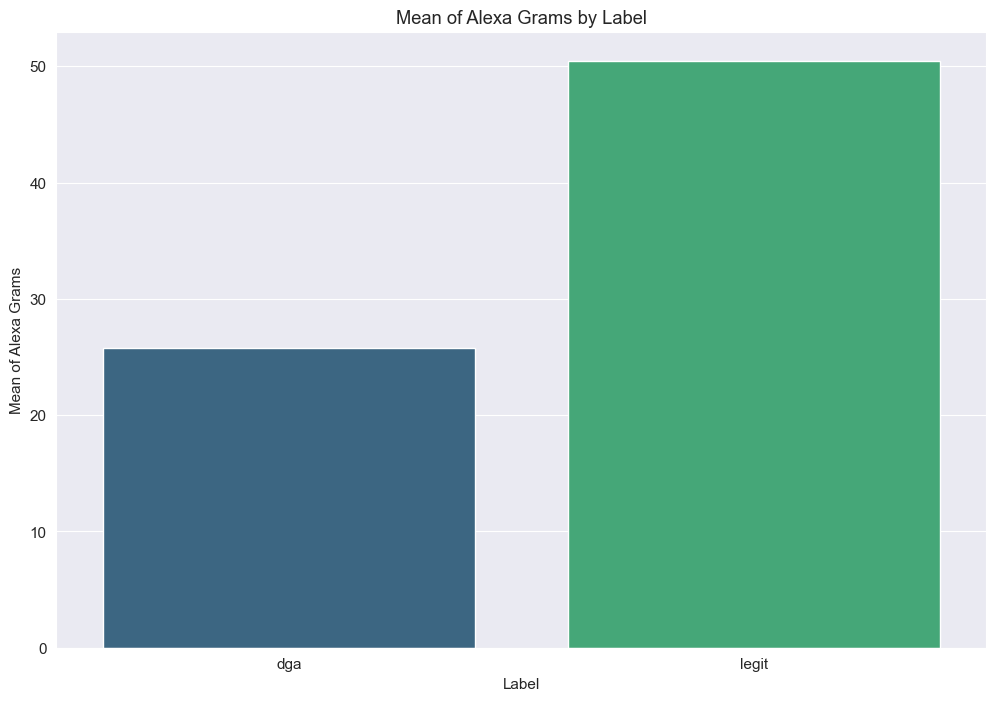

In [114]:
sns.barplot(x=mean_alexa_grams.index, y=mean_alexa_grams.values, palette="viridis")

plt.ylabel("Mean of Alexa Grams")
plt.xlabel("Label")
plt.title("Mean of Alexa Grams by Label")
plt.show()

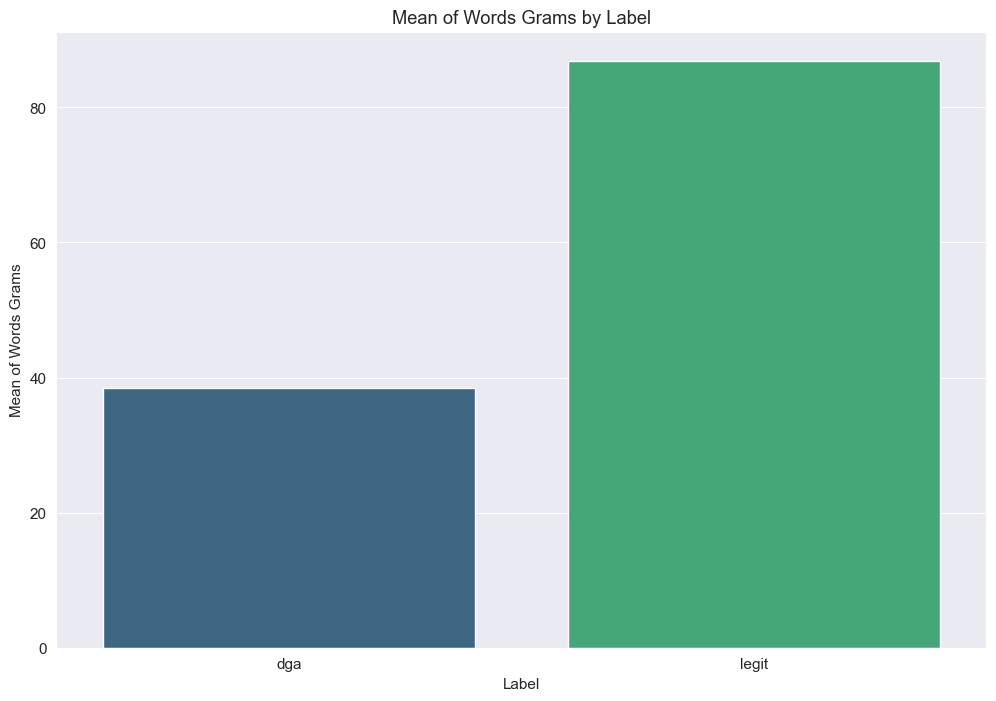

In [117]:
sns.barplot(x=mean_words_grams.index, y=mean_words_grams.values, palette="viridis")

plt.ylabel("Mean of Words Grams")
plt.xlabel("Label")
plt.title("Mean of Words Grams by Label")
plt.show()

<Axes: xlabel='length', ylabel='alexa_grams'>

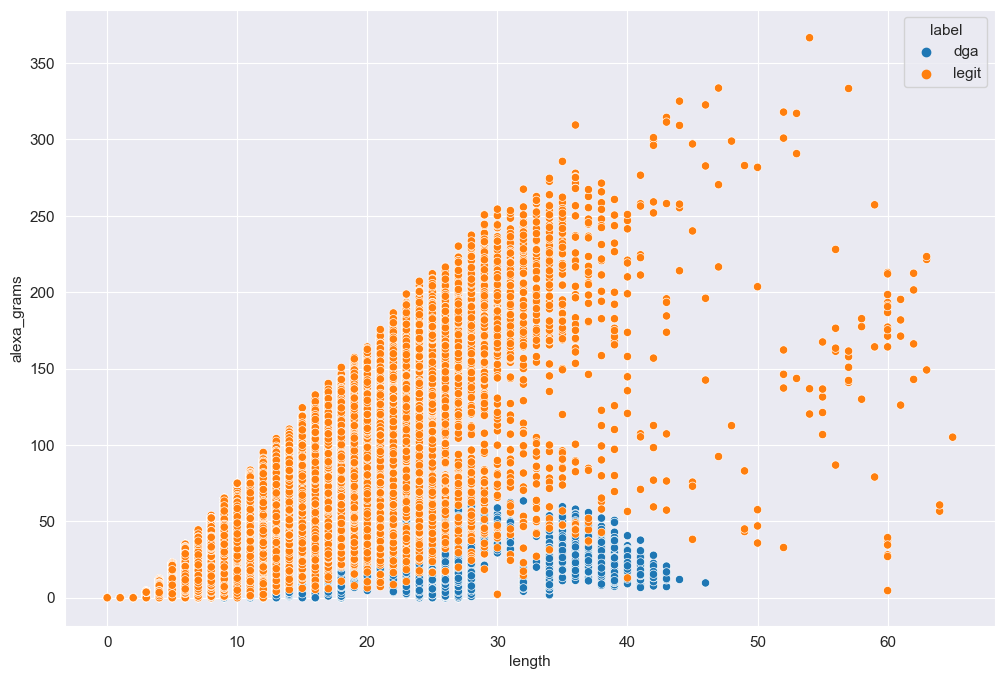

In [118]:
sns.scatterplot(data=data, x="length", y="alexa_grams", hue="label")

<Axes: xlabel='entropy', ylabel='alexa_grams'>

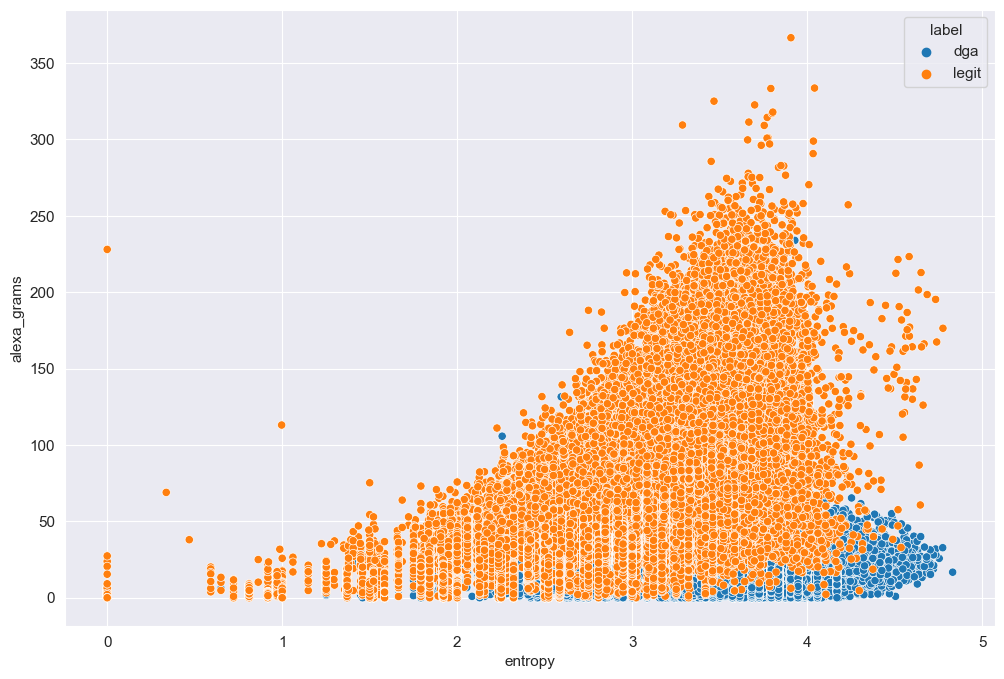

In [119]:
sns.scatterplot(data=data, x="entropy", y="alexa_grams", hue="label")

<Axes: xlabel='length', ylabel='words_grams'>

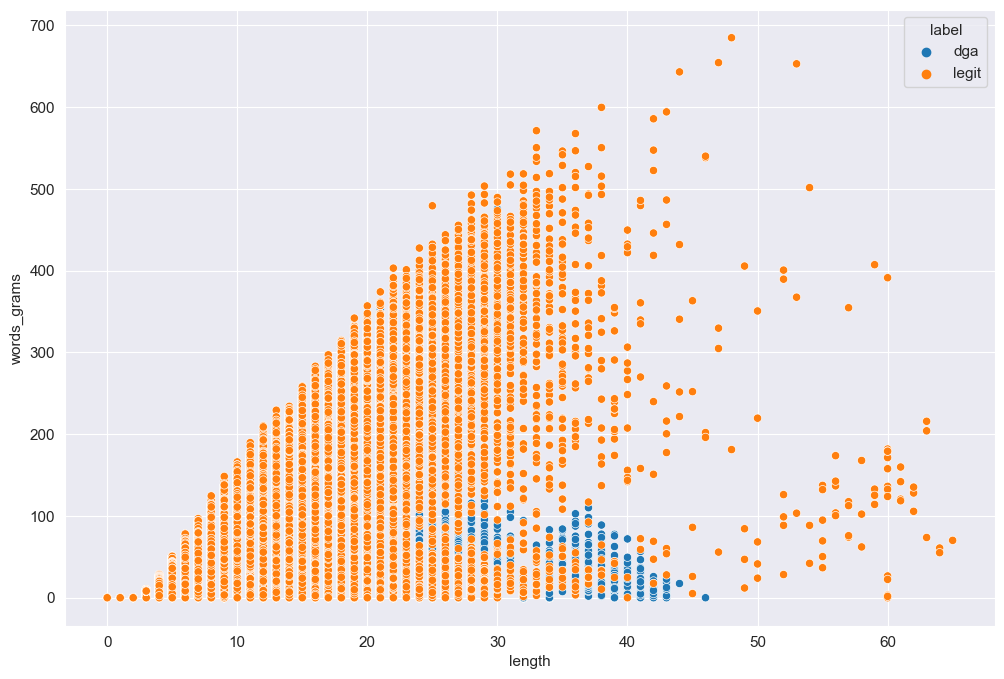

In [120]:
sns.scatterplot(data=data, x="length", y="words_grams", hue="label")

<Axes: xlabel='entropy', ylabel='words_grams'>

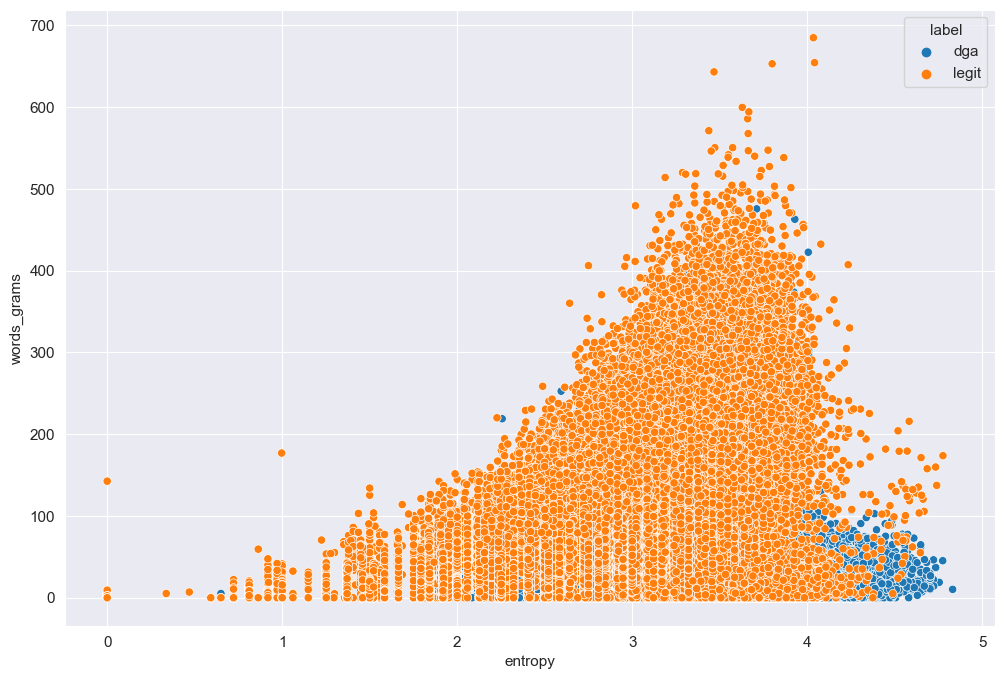

In [121]:
sns.scatterplot(data=data, x="entropy", y="words_grams", hue="label")

In [122]:
X_dash = data.drop(["label", "domain_name", "domain"], axis=1)
y_dash = data["label"]

X_dash_train, X_dash_test, y_dash_train, y_dash_test = train_test_split(X_dash, y_dash, train_size=0.8, test_size=0.2, shuffle=True, stratify=y_dash)

In [123]:
lb_dash = LabelEncoder()

y_dash_train = lb_dash.fit_transform(y_dash_train)
y_dash_test = lb_dash.transform(y_dash_test)

In [124]:
lgb_clf_dash = lgb.LGBMClassifier()

lgb_clf_dash.fit(X_dash_train, y_dash_train)
y_dash_pred = lgb_clf_dash.predict(X_dash_test)

[LightGBM] [Info] Number of positive: 555829, number of negative: 555830
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 1111659, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000002
[LightGBM] [Info] Start training from score -0.000002


In [125]:
print("Accuracy score is {}%".format(round(accuracy_score(y_dash_test, y_dash_pred) * 100), 3))
print("Evaluation f1 score metric is {}%".format(round(f1_score(y_dash_test, y_dash_pred) * 100), 3))

Evaluation f1 score metric is 98%


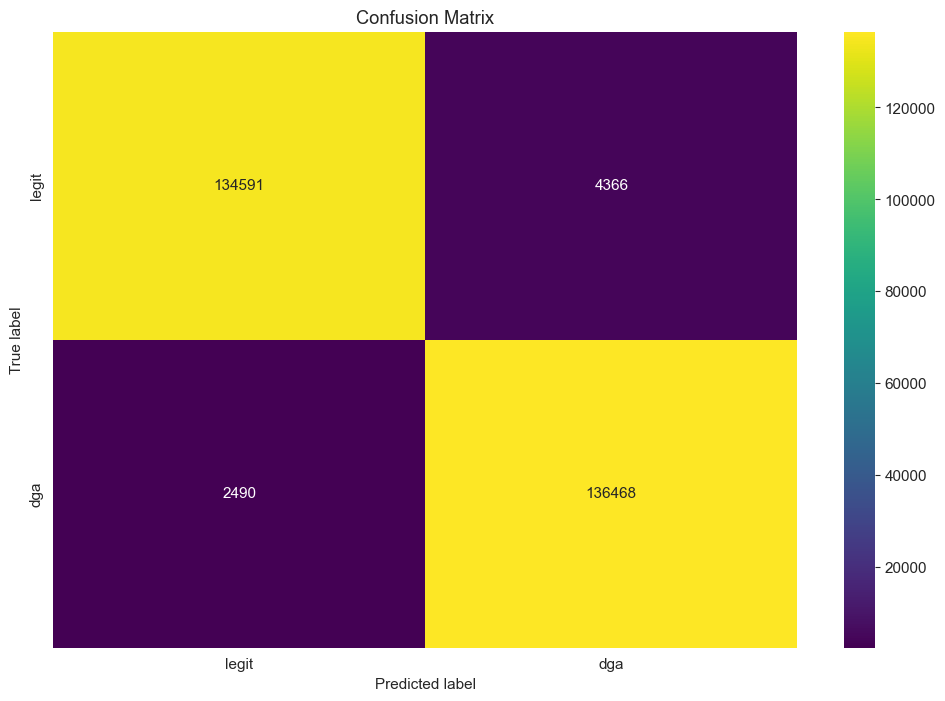

In [129]:
# Calculate confusion matrix
cm = confusion_matrix(y_dash_test, y_dash_pred)

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=["legit", "dga"], yticklabels=["legit", "dga"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [131]:
# Save Model Weights and Architecture Together
# The Gradient boosting classifier had the best results so we will save it's model
import joblib
model = open("../models/DGA.pkl","wb")
joblib.dump(lgb_clf_dash, model)
model.close()

In [133]:
data.head()


,domain_name,label,domain,length,entropy,alexa_grams,words_grams
0,vvqbhhwma.org,dga,vvqbhhwma,9,2.725481,3.480582,4.430817
1,cfhauqbaz.com,dga,cfhauqbaz,9,2.947703,11.153124,14.986492
2,bvxjsbkqu.biz,dga,bvxjsbkqu,9,2.947703,4.006466,0.000000
3,hggazskvkdy.com,dga,hggazskvkdy,11,3.095795,11.862345,10.112126
4,xgoqyxgfgm.com,dga,xgoqyxgfgm,10,2.646439,3.497759,0.000000


In [134]:
data.to_csv("DGA_Processed.csv")